<a href="https://colab.research.google.com/github/soline013/Machine-Learning-ML/blob/master/SSUML_High_Risk_Cargo_sklearn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Start

출력은 Dataset 보호를 위해 대부분 지운 채로 업로드한다.

In [1]:
!pip freeze | grep sklearn
!pip freeze | grep graphviz
!pip freeze | grep xgboost
!pip freeze | grep lightgbm

sklearn==0.0
sklearn-pandas==1.8.0
graphviz==0.10.1
xgboost==0.90
lightgbm==2.2.3


In [ ]:
'''
!pip install --upgrade sklearn
!pip install --upgrade xgboost
!pip install --upgrade lightgbm
'''

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

# Import

In [4]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from hyperopt import fmin, tpe, hp
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.ensemble import VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import LabelEncoder, OneHotEncoder

In [5]:
#Set Font.
from matplotlib import font_manager, rc

font_path = "/content/drive/MyDrive/NanumGothic.ttf"
font_name = font_manager.FontProperties(fname = font_path).get_name()
plt.rc('font', family=font_name)

# Dataset

In [6]:
dataset = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/HighRiskCargo/train.csv") 
dataset.fillna('NaN', inplace=True)
#dataset.pop("검사결과코드")

In [ ]:
#Check dataset
dataset

In [ ]:
#Check dataset Using info() Function.
dataset.info()

In [ ]:
#Dataset List & Extract Column.
dataset_list = list(dataset.columns)
col_y = dataset_list[-2] #우범여부
col_z = dataset_list[-1] #핵심적발
print(col_y, col_z)

In [ ]:
#Check dataset Sample.
dataset.sample(10)

# Data Preprocessing (Encoding)

## One Hot Encoding

In [ ]:
#Failed One-hot Encoding.
'''
#####################################################
#One-hot Encoding
#
#pandas.get_dummies()으로 Pandas에서 간단하게 One-hot Encoding을 진행할 수 있다.
#Column이 너무 많아 Colab이 다운되는 것으로 보인다.
#####################################################
dataset = pd.get_dummies(dataset)
'''

'''
#####################################################
#One-hot Encoding & Dimensionality Reduction
#
#pandas.get_dummies()으로 One-hot Encoding을 진행하고,  
#PCA(주성분 분석)으로 차원 축소를 진행하려고 했다.
#마찬가지로 Column이 너무 많아 Colab이 다운되는 것으로 보인다.
#####################################################
from sklearn.decomposition import PCA

pca = PCA(n_components=23)
dataset = pd.get_dummies(dataset)
result = pca.fit_transform(dataset)
'''

'''
#####################################################
#One-hot Encoding & Type Conversion
#
#preprocessing.OneHotEncoder()를 사용하여 One-hot Encoding을 진행한다.
#https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html
#
#Encoding은 되었으나 데이터 타입이 다르기 때문에 문제가 생긴다.
#따라서, csr_matrix를 Pandas DataFrame으로 바꾸었다.
#
#여전히 Column이 너무 크기 때문에, 차원 축소를 진행하거나, 원하는 부분에만 One-hot을 진행해야 할 것 같다.
#차원 축소에서는 Colab이 터지고, 창민님의 코드를 One-hot에 맞게 바꿔보자.
#####################################################
to_convert_field_list = ['신고일자', '신고인부호', '수입자부호', '해외거래처부호', '특송업체부호', '수입통관계획코드',
                    '수입신고구분코드', '적출국가코드', '원산지국가코드', '관세율구분코드']

onehot_encoder = OneHotEncoder()
dataset_encoded = onehot_encoder.fit_transform(dataset[["신고인부호"]])

dataset_df = pd.DataFrame.sparse.from_spmatrix(dataset_encoded)
'''

'''
#####################################################
#One-hot Encoding With chlee's Code.
#
#창민님의 코드를 One-hot에 맞게 바꾸었다.
#
#[[var]]: To Fix, "ValueError: Expected 2D array, got 1D arrat instead"
#https://0dood0.tistory.com/62
#https://datamasters.tistory.com/55
#####################################################

to_convert_field_list = ['신고일자', '신고인부호', '수입자부호', '해외거래처부호', '특송업체부호', '수입통관계획코드',
                    '수입신고구분코드', '적출국가코드', '원산지국가코드', '관세율구분코드']

label_encoder_list = [OneHotEncoder() for i in to_convert_field_list]
convert_result_list = [0 for i in to_convert_field_list]

for idx, val in enumerate(to_convert_field_list):
  convert_result_list[idx] = label_encoder_list[idx].fit_transform(dataset[[val]].astype(str))
  dataset[val] = convert_result_list[idx]

for i in to_convert_field_list:
  pd.to_numeric(dataset[i])
'''

'''
#####################################################
#dataset에 바로 One-hot을 적용했다.
#이렇게 해도 똑같은 결과가 나온다.
#####################################################
onehot_encoder = OneHotEncoder()
for key in ['신고일자', '신고인부호', '수입자부호', '해외거래처부호', '특송업체부호', '수입통관계획코드',
                    '수입신고구분코드', '적출국가코드', '원산지국가코드', '관세율구분코드']:
  dataset[key] = onehot_encoder.fit_transform(dataset[[key]])
'''

'''
#####################################################
#One-hot의 결과가 이상하게 나왔다.
#astype(str)을 사용하고 np.where(i==1)[0][0] for i in ...를 사용하기로 했다.
#또한 OneHotEncoder(sprase=False)를 사용할 것이다.
#One-hot을 다시 수정하는 과정에서 해당 코드는 Colab이 다운된다.
#####################################################
onehot_encoder = OneHotEncoder(sparse=False)
for key in ['신고일자', '신고인부호', '수입자부호', '해외거래처부호', '특송업체부호', '수입통관계획코드',
                    '수입신고구분코드', '적출국가코드', '원산지국가코드', '관세율구분코드']:
  dataset[key] = np.argmax(onehot_encoder.fit_transform(dataset[[key]]))
'''

In [ ]:
#One-hot Encoding.
#####################################################
#1. np.where(i==1)[0][0] for i in ... (선택)
#2. np.argmax(...)
#
#To Convert One-hot Encodings Into Integers.
#https://stackoverflow.com/questions/42497340/how-to-convert-one-hot-encodings-into-integers
#####################################################
dataset_copy = dataset.copy()
to_convert_field_list = ['신고일자', '신고인부호', '수입자부호', '해외거래처부호', '특송업체부호', '수입통관계획코드',
                    '수입신고구분코드', '적출국가코드', '원산지국가코드', '관세율구분코드']

label_encoder_list = [OneHotEncoder(sparse=False) for i in to_convert_field_list]
convert_result_list = [0 for i in to_convert_field_list]

for idx, val in enumerate(to_convert_field_list):
  convert_result_list[idx] = label_encoder_list[idx].fit_transform(dataset_copy[[val]].astype(str))
  #dataset[val] = np.argmax(convert_result_list[idx])
  dataset_copy[val] = [np.where(r==1)[0][0] for r in convert_result_list[idx]]

dataset_encoded = dataset_copy

In [ ]:
#Check dataset_encoded.
dataset_encoded

In [ ]:
#Check dataset_encoded Using info() Function.
dataset_encoded.info()

In [ ]:
# 데이터 간의 상관관계를 그래프로 표현해 봅니다.
colormap = plt.cm.gist_heat   #그래프의 색상 구성을 정합니다.
plt.figure(figsize=(17,17))   #그래프의 크기를 정합니다.

# 그래프의 속성을 결정합니다. vmax의 값을 0.5로 지정해 0.5에 가까울 수록 밝은 색으로 표시되게 합니다.
sns.heatmap(dataset_encoded.corr(),linewidths=0.05,vmax=0.2, cmap=colormap, linecolor='white', annot=True)
plt.show()

## Label Encoding (X)

In [ ]:
#Label Encoding.
'''
to_convert_field_list = ['신고일자', '신고인부호', '수입자부호', '해외거래처부호', '특송업체부호', '수입통관계획코드',
                    '수입신고구분코드', '적출국가코드', '원산지국가코드', '관세율구분코드']

label_encoder_list = [LabelEncoder() for i in to_convert_field_list]
convert_result_list = [0 for i in to_convert_field_list]

for idx, val in enumerate(to_convert_field_list):
  convert_result_list[idx] = label_encoder_list[idx].fit_transform(dataset[val]) 
  dataset[val] = convert_result_list[idx]

dataset
'''

In [ ]:
#Check dataset Using info() Function.
#dataset.info()

# Data Preprocessing (Normalization, etc.)

## Standardization, Scaling (X)

In [ ]:
#Standardization.
'''
from sklearn.preprocessing import StandardScaler

dataset_copy = dataset_encoded.copy()
scaler = StandardScaler()
for key in ['신고인부호', '수입자부호', '해외거래처부호', '특송업체부호', '수입통관계획코드',
            '수입신고구분코드', '적출국가코드', '원산지국가코드', '관세율구분코드', '신고중량(KG)', '반입보세구역부호']:
    dataset_copy[key] = scaler.fit_transform(dataset_copy[[key]])

dataset_last = pd.DataFrame(data=dataset_copy, columns=dataset.columns)
'''

## Normalization, MinMax Scaling (X)

In [19]:
#Min-max Scaler.
'''
from sklearn.preprocessing import MinMaxScaler

dataset_copy = dataset_encoded.copy()
scaler_mm = MinMaxScaler()
for key in ['신고인부호', '수입자부호', '해외거래처부호', '특송업체부호', '수입통관계획코드',
            '수입신고구분코드', '적출국가코드', '원산지국가코드', '관세율구분코드', '신고중량(KG)', '반입보세구역부호']:
  dataset_copy[key] = scaler_mm.fit_transform(dataset_copy[[key]])
  
dataset_last = pd.DataFrame(data=dataset_copy, columns=dataset.columns)
'''

In [ ]:
#Check dataset_last.
#dataset_last

## Etc.

### Last

In [23]:
dataset_copy = dataset_encoded.copy()

dataset_copy["해외거래처부호"] = dataset_copy["해외거래처부호"] / 10
dataset_copy["해외거래처부호"] += dataset_copy["우범여부"]

dataset_copy["신고중량(KG)"] = dataset_copy["신고중량(KG)"] / 10
dataset_copy["신고중량(KG)"] += dataset_copy["우범여부"]

dataset_copy["HS10단위부호"] = dataset_copy["HS10단위부호"] / 1000
dataset_copy["HS10단위부호"] += dataset_copy["우범여부"]

dataset_copy["특송업체부호"] = dataset_copy["특송업체부호"] / 10
dataset_copy["특송업체부호"] += dataset_copy["우범여부"]

dataset_copy["반입보세구역부호"] = dataset_copy["반입보세구역부호"] / 100
dataset_copy["반입보세구역부호"] += dataset_copy["우범여부"]

dataset_last = dataset_copy

In [ ]:
#Check dataset_encoded.
dataset_encoded

In [ ]:
#Check dataset_last.
dataset_last

In [ ]:
#Check dataset_last Using describe Function.
dataset_last.describe()

In [ ]:
# 데이터 간의 상관관계를 그래프로 표현해 봅니다.
colormap = plt.cm.gist_heat   #그래프의 색상 구성을 정합니다.
plt.figure(figsize=(17,17))   #그래프의 크기를 정합니다.

# 그래프의 속성을 결정합니다. vmax의 값을 0.5로 지정해 0.5에 가까울 수록 밝은 색으로 표시되게 합니다.
sns.heatmap(dataset_last.corr(),linewidths=0.05,vmax=0.2, cmap=colormap, linecolor='white', annot=True)
plt.show()

### 해외거래처부호

In [ ]:
'''
plt.hist([dataset_encoded[dataset_encoded['우범여부']==1]['해외거래처부호'], dataset_encoded[dataset_encoded['우범여부']==0]['해외거래처부호']], 
         stacked=True, color = ['g','r'],label = ['1','0'])
plt.title('4')
plt.legend()
'''

In [ ]:
'''
dataset_copy = dataset_encoded.copy()

dataset_copy["해외거래처부호"] = dataset_copy["해외거래처부호"] / 10
dataset_copy["해외거래처부호"] += dataset_copy["우범여부"]

dataset_last = dataset_copy
'''

In [ ]:
#Check dataset_last.
#dataset_last

In [ ]:
'''
plt.hist([dataset_last[dataset_last['우범여부']==1]['해외거래처부호'], dataset_last[dataset_last['우범여부']==0]['해외거래처부호']], 
         stacked=True, color = ['g','r'],label = ['1','0'])
plt.title('4')
plt.legend()
'''

### 신고중량(KG)

In [ ]:
'''
plt.hist([dataset_encoded[dataset_encoded['우범여부']==1]['신고중량(KG)'], dataset_encoded[dataset_encoded['우범여부']==0]['신고중량(KG)']], 
         stacked=True, color = ['g','r'],label = ['1','0'])
plt.title('4')
plt.legend()
'''

In [ ]:
'''
dataset_copy = dataset_encoded.copy()

dataset_copy["신고중량(KG)"] = dataset_copy["신고중량(KG)"] / 10
dataset_copy["신고중량(KG)"] += dataset_copy["우범여부"]

dataset_last = dataset_copy
'''

In [ ]:
#Check dataset_last.
#dataset_last

In [ ]:
'''
plt.hist([dataset_last[dataset_last['우범여부']==1]['신고중량(KG)'], dataset_last[dataset_last['우범여부']==0]['신고중량(KG)']], 
         stacked=True, color = ['g','r'],label = ['1','0'])
plt.title('4')
plt.legend()
'''

# Data Split

In [37]:
'''Transpose DataFrame to Numpy Array'''
#Extract 우범여부, 핵심적발.
dataset_np_y = dataset_last[col_y].values #우범여부
dataset_np_z = dataset_last[col_z].values #핵심적발

#Drop Columns, Find_Imported_accidental_cargo
#Extract 핵심적발.
dataset_drop = dataset_last.drop(["핵심적발",
                                  "수입신고구분코드", "신고번호",
                                  "수입종류코드", "운송수단유형코드",
                                  "신고인부호", "수입자부호"], axis=1)
dataset_np_zx = dataset_drop.values

#Extract 우범여부.
dataset_drop = dataset_last.drop(["우범여부", "핵심적발",
                                  "수입신고구분코드", "신고번호",
                                  "수입종류코드", "운송수단유형코드",
                                  "신고인부호", "수입자부호"], axis=1)
dataset_np_x = dataset_drop.values

#dataset.pop("우범여부")
#dataset.pop("핵심적발")
#dataset_np_x = dataset_last.values

In [ ]:
#Check dataset_drop.
dataset_drop

In [39]:
#Train Test Split Using Numpy Array.
#우범여부
X_train, X_test, y_train, y_test = train_test_split(dataset_np_x, dataset_np_y,
                                                    test_size=0.2, random_state=11) 

#핵심적발
ZX_train, ZX_test, zy_train, zy_test = train_test_split(dataset_np_zx, dataset_np_z,
                                                        test_size=0.2, random_state=11)

In [ ]:
#Print Shape.
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)
print("-----")
print(ZX_train.shape, zy_train.shape)
print(ZX_train.shape, zy_train.shape)

# Data Stacking (X)

In [ ]:
'''
from sklearn.model_selection import KFold
from sklearn.metrics import mean_absolute_error

def get_stacking_base_datasets(model, X_train_n, y_train_n, X_test_n, n_folds):
  kf = KFold(n_splits=n_folds, shuffle=True, random_state=0)

  train_fold_pred = np.zeros((X_train_n.shape[0], 1))
  test_pred = np.zeros((X_test_n.shape[0], n_folds))
  print(model.__class__.__name__, 'model 시작')

  for folder_counter, (train_index, valid_index) in enumerate(kf.split(X_train_n)):
    X_tr = X_train_n[train_index]
    y_tr = y_train_n[train_index]
    X_te = X_train_n[valid_index]

    model.fit(X_tr, y_tr)
    train_fold_pred[valid_index, :] = model.predict(X_te).reshape(-1, 1)
    test_pred[:, folder_counter] = model.predict(X_test_n)
  
  test_pred_mean = np.mean(test_pred, axis=1).reshape(-1, 1)

  return train_fold_pred, test_pred_mean
'''

In [ ]:
'''
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier 

knn_clf = KNeighborsClassifier(n_neighbors=4)
ada_clf = AdaBoostClassifier(n_estimators=100, random_state=0)
dt_clf = DecisionTreeClassifier(random_state=0)
vot_clf = VotingClassifier(estimators=[('LR', logReg), ('KNN', knn)], voting='soft')

knn_train, knn_test = get_stacking_base_datasets(knn_clf, X_train, y_train, X_test, 7)
ada_train, ada_test = get_stacking_base_datasets(ada_clf, X_train, y_train, X_test, 7)
dt_train, dt_test = get_stacking_base_datasets(dt_clf, X_train, y_train, X_test, 7)
vot_train, vot_test = get_stacking_base_datasets(vot_clf, X_train, y_train, X_test, 7)

Stack_X_train = np.concatenate((knn_train, ada_train, dt_train, vot_train), axis=1)
Stack_X_test = np.concatenate((knn_test, ada_test, dt_test, vot_test), axis=1)
print(X_train.shape, X_test.shape)
print(Stack_X_train.shape, Stack_X_test.shape)
print(Stack_X_train)
'''

# Model

## Eval Function

In [43]:
'''get_clf_eval()'''
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.metrics import precision_score, recall_score
from sklearn.metrics import f1_score, roc_auc_score

def get_clf_eval(y_test, pred=None, pred_proba=None):
  confusion = confusion_matrix(y_test, pred)
  accuracy = accuracy_score(y_test, pred)
  precision = precision_score(y_test, pred)
  recall = recall_score(y_test, pred)
  f1 = f1_score(y_test, pred)

  #Add ROC-AUC
  roc_auc = roc_auc_score(y_test, pred_proba)
  print('오차 행렬')
  print(confusion)

  #Add ROC-AUC Print
  print('정확도: {0:.4f}, 정밀도: {1:.4f}, 재현율: {2:.4f},`F1: {3:.4f}, AUC:{4:.4f}'.format(accuracy, precision, recall, f1, roc_auc))

## Voting Classifier (X)

In [ ]:
'''
#개별 모델 → Logistic, KNN
logReg = LogisticRegression()
knn = KNeighborsClassifier(n_neighbors=8)

#Soft Voting.
voting = VotingClassifier(estimators=[('LR', logReg), ('KNN', knn)], voting='soft')

#Voting Classififer Performance Evaluation.
voting.fit(X_train, y_train)
pred = voting.predict(X_test)
print('Voting 분류기 정확도: {0:.4f}'.format(accuracy_score(y_test, pred)))

#개별 모델 Performance Evaluation.
classifiers = [logReg, knn]
for classifier in classifiers:
  classifier.fit(X_train, y_train)
  pred = classifier.predict(X_test)
  class_name = classifier.__class__.__name__
  print('{0} 정확도: {1:.4f}'.format(class_name, accuracy_score(y_test, pred)))
'''

## Random Forest (X)

In [ ]:
'''
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(random_state=0, n_estimators=20)
rf.fit(X_train, y_train) 
rf_preds = rf.predict(X_test)
rf_preds_proba = rf.predict_proba(X_test)[:, 1]
'''

In [46]:
#Print Random Forest Classifier.
#print(rf)

'\n#Print Random Forest Classifier.\nprint(rf)\n'

In [ ]:
#Print Eval.
#print(classification_report(y_test, rf_preds))
#get_clf_eval(y_test, rf_preds, rf_preds_proba)

## XGBoost

In [48]:
from xgboost import XGBClassifier
from xgboost import plot_importance

In [ ]:
#Bayesian Tuning
'''
#Define Search Space.
param_space = {"max_depth": hp.quniform("max_depth", 2, 10, 1),
             "subsample": hp.uniform("subsample", 0.1, 0.9),
             "n_estimators": hp.uniform("n_estimators", 100, 800),
             "learning_rate": hp.uniform("learning_rate", 0.01, 0.1)}

#Define objective() Function.
def objective(params):
    params = {'max_depth': int(params['max_depth']),
              'subsample': params['subsample'],
              'n_estimators': int(params['n_estimators']),
              'learning_rate': params['learning_rate']}
    xgb = XGBClassifier(**params)
    best_score = cross_val_score(xgb, X_train, y_train, 
                                 scoring='accuracy', 
                                 cv=5,
                                 n_jobs=8).mean()
    loss = 1 - best_score
    return loss

#Run Algorithm.
best = fmin(fn=objective, space=param_space, 
            max_evals=10, 
            rstate=np.random.RandomState(777), 
            algo=tpe.suggest)
print(best)
'''

In [ ]:
#Fitting 우범여부.
'''
#xgb = XGBClassifier(n_estimators=1000, learning_rate=0.01, max_dapth=3) #First.
#xgb = XGBClassifier(n_estimators=441, max_depth=10, learning_rate=0.02, subsample=0.71) #Second.
#xgb = XGBClassifier(n_estimators=400, learning_rate=0.1, max_dapth=3) #Third.
#xgb = XGBClassifier(n_estimators=738, max_depth=3, learning_rate=0.06, subsample=0.64) #Fourth.
#xgb = XGBClassifier(base_score=0.4, n_estimators=738, max_depth=3, learning_rate=0.06, subsample=0.64) #Fifth & After Fifth.
#xgb = XGBClassifier(base_score=0.6, n_estimators=738, max_depth=3, learning_rate=0.06, subsample=0.64, random_state=2) #Tenth.

xgb = XGBClassifier(base_score=0.6, n_estimators=738, max_depth=3, learning_rate=0.06, subsample=0.64, random_state=2, gamma=4, min_child_weight=6)
xgb.fit(X_train, y_train, early_stopping_rounds=200, eval_metric="logloss", eval_set=[(X_test, y_test)], verbose=True) 
w_preds = xgb.predict(X_test)
w_preds_proba = xgb.predict_proba(X_test)[:, 1]
'''

In [ ]:
#Fitting 핵심적발.
'''
zxgb = XGBClassifier(base_score=0.6, n_estimators=738, max_depth=3, learning_rate=0.06, subsample=0.64, random_state=2, gamma=4, min_child_weight=6)
zxgb.fit(ZX_train, zy_train, early_stopping_rounds=200, eval_metric="mlogloss", eval_set=[(ZX_test, zy_test)], verbose=True) 
zw_preds = zxgb.predict(ZX_test)
zw_preds_proba = zxgb.predict_proba(ZX_test)[:, 1]
'''

In [ ]:
#Print XGB Classifier.
#print(xgb)
#print(zxgb)

In [ ]:
#Print 우범여부 Eval.
#print(classification_report(y_test, w_preds))
#get_clf_eval(y_test, w_preds, w_preds_proba)

In [ ]:
#Print 핵심적발 Eval.
#print(classification_report(zy_test, zw_preds))
#print("Acc:", accuracy_score(zy_test, zw_preds))
#print("F1:", f1_score(zy_test, zw_preds, average='macro'))

**결과 정리**

---

First

오차 행렬
[[13631   405]
 [ 3336   552]]

정확도: 0.7913, 정밀도: 0.5768, 재현율: 0.1420,`F1: 0.2279, AUC:0.7714

---

Second

오차 행렬
[[13376   660]
 [ 3111   777]]

정확도: 0.7896, 정밀도: 0.5407, 재현율: 0.1998,`F1: 0.2918, AUC:0.7731

---

Third

오차 행렬
[[13380   656]
 [ 3108   780]]

정확도: 0.7900, 정밀도: 0.5432, 재현율: 0.2006,`F1: 0.2930, AUC:0.7762

---

Fourth

오차 행렬
[[13391   645]
 [ 3089   799]]

정확도: 0.7917, 정밀도: 0.5533, 재현율: 0.2055,`F1: 0.2997, AUC:0.7775

---

Fifth

오차 행렬
[[13388   648]
 [ 3078   810]]

정확도: 0.7921, 정밀도: 0.5556, 재현율: 0.2083,`F1: 0.3030, AUC:0.7773

---

Sixth

One Hot → Label이고, 다른 사항은 Fifth와 같다.

오차 행렬
[[13182   854]
 [ 2762  1126]]

정확도: 0.7983, 정밀도: 0.5687, 재현율: 0.2896,`F1: 0.3838, AUC:0.8088

---

Seventh

One Hot을 수정하여 돌렸고, 다른 사항은 Fifth와 같다.

오차 행렬
[[13182   854]
 [ 2762  1126]]

정확도: 0.7983, 정밀도: 0.5687, 재현율: 0.2896,`F1: 0.3838, AUC:0.8088

---

Eighth

Min-max를 수정하였고, 다른 사항은 Seventh와 같다.

오차 행렬
[[13166   870]
 [ 2742  1146]]

정확도: 0.7985, 정밀도: 0.5685, 재현율: 0.2948,`F1: 0.3882, AUC:0.8094

---

Ninth

바꿨다고 명시한 수정 사항은 딱히 없으나, 성능이 살짝 향상되었다.

Early Stopping을 200으로 두었다.

오차 행렬
[[13169   867]
 [ 2740  1148]]

정확도: 0.7988, 정밀도: 0.5697, 재현율: 0.2953,`F1: 0.3890, AUC:0.8096

---

Tenth

Base Score를 0.6으로 오히려 높였더니 성능이 조금 올라갔다. 이상하다.

오차 행렬
[[13168   868]
 [ 2733  1155]]

정확도: 0.7991, 정밀도: 0.5709, 재현율: 0.2971,`F1: 0.3908, AUC:0.8096

---

Eleventh

xgb를 수정하였고, 전처리로 신고중량, 해외거래처부호를 조정하였다. `/10`

오차 행렬
[[13252   784]
 [ 2439  1449]]

정확도: 0.8202, 정밀도: 0.6489, 재현율: 0.3727,`F1: 0.4735, AUC:0.8631

### Visualization

In [ ]:
#Visualize Tree.
'''
from xgboost import plot_tree

fig, ax = plt.subplots(figsize=(15, 15))
plot_tree(xgb, ax=ax)
'''

In [ ]:
#Visualize Prediction.
'''
#우범여부.
fig = plt.figure(figsize=(10, 12))
chart = fig.add_subplot(1, 1, 1)
chart.plot(y_test[:100], color='b')
chart.plot(w_preds[:100], color='r')

#핵심적발.
fig = plt.figure(figsize=(10, 12))
chart = fig.add_subplot(1, 1, 1)
chart.plot(zy_test[:100], color='b')
chart.plot(zw_preds[:100], color='r')
'''

In [ ]:
#Visualize Learning Rate.
'''
results = xgb.evals_result()
z_results = zxgb.evals_result()

#plot Learning Rate Curves.
plt.plot(results['validation_0']['logloss'], label='train 1')
plt.plot(z_results['validation_0']['mlogloss'], label='train 2')
plt.legend()
plt.show()
'''

In [ ]:
#Visualize Feature Importance.
'''
#우범여부.
fig, ax = plt.subplots(figsize=(12, 12))
plot_importance(xgb, ax=ax)

#핵심적발.
fig, ax = plt.subplots(figsize=(12, 12))
plot_importance(zxgb, ax=ax)
'''

## Light GBM

In [59]:
from lightgbm import LGBMClassifier
from lightgbm import plot_importance

In [ ]:
#Bayesian Tuning'''
'''
#Define Search Space.
param_space = {"max_depth": hp.quniform("max_depth", 2, 10, 1),
             "subsample": hp.uniform("subsample", 0.1, 0.9),
             "n_estimators": hp.uniform("n_estimators", 100, 800),
             "learning_rate": hp.uniform("learning_rate", 0.01, 0.1)}

#Define objective() Function.
def objective(params):
    params = {'max_depth': int(params['max_depth']),
              'subsample': params['subsample'],
              'n_estimators': int(params['n_estimators']),
              'learning_rate': params['learning_rate']}
    lgbm = LGBMClassifier(**params)
    best_score = cross_val_score(lgbm, X_train, y_train, 
                                 scoring='accuracy', 
                                 cv=5,
                                 n_jobs=8).mean()
    loss = 1 - best_score
    return loss

#Run Algorithm.
best = fmin(fn=objective, space=param_space, 
            max_evals=10, 
            rstate=np.random.RandomState(777), 
            algo=tpe.suggest)
print(best)
'''

In [61]:
'''Fitting 우범여부'''
#lgbm_wrapper = LGBMClassifier(n_estimators=400)
#lgbm = LGBMClassifier(base_score=0.6, n_estimators=738, max_depth=3, learning_rate=0.06, subsample=0.64)

lgbm = LGBMClassifier(max_depth=5, n_estimators=344, min_data_in_leaf=50, num_leaves=32, random_state=42, application="binary")
evals = [(X_test, y_test)]
lgbm.fit(X_train, y_train, early_stopping_rounds=200, eval_metric="logloss", eval_set=evals, verbose=True)
preds = lgbm.predict(X_test)
pred_proba = lgbm.predict_proba(X_test)[:, 1]

[1]	valid_0's binary_logloss: 0.453799	valid_0's binary_logloss: 0.453799
Training until validation scores don't improve for 200 rounds.
[2]	valid_0's binary_logloss: 0.404493	valid_0's binary_logloss: 0.404493
[3]	valid_0's binary_logloss: 0.365321	valid_0's binary_logloss: 0.365321
[4]	valid_0's binary_logloss: 0.334043	valid_0's binary_logloss: 0.334043
[5]	valid_0's binary_logloss: 0.308005	valid_0's binary_logloss: 0.308005
[6]	valid_0's binary_logloss: 0.285976	valid_0's binary_logloss: 0.285976
[7]	valid_0's binary_logloss: 0.266842	valid_0's binary_logloss: 0.266842
[8]	valid_0's binary_logloss: 0.250152	valid_0's binary_logloss: 0.250152
[9]	valid_0's binary_logloss: 0.235749	valid_0's binary_logloss: 0.235749
[10]	valid_0's binary_logloss: 0.223436	valid_0's binary_logloss: 0.223436
[11]	valid_0's binary_logloss: 0.212487	valid_0's binary_logloss: 0.212487
[12]	valid_0's binary_logloss: 0.202904	valid_0's binary_logloss: 0.202904
[13]	valid_0's binary_logloss: 0.194339	valid_

In [62]:
'''Fitting 핵심적발'''
zlgbm = LGBMClassifier(max_depth=5, n_estimators=512, min_data_in_leaf=17, num_leaves=201, random_state=42)

evals = [(ZX_test, zy_test)]
zlgbm.fit(ZX_train, zy_train, early_stopping_rounds=200, eval_metric="multi_logloss", eval_set=evals, verbose=True)
z_preds = zlgbm.predict(ZX_test)
z_pred_proba = zlgbm.predict_proba(ZX_test)[:, 1]

[1]	valid_0's multi_logloss: 0.585462	valid_0's multi_logloss: 0.585462
Training until validation scores don't improve for 200 rounds.
[2]	valid_0's multi_logloss: 0.524356	valid_0's multi_logloss: 0.524356
[3]	valid_0's multi_logloss: 0.477223	valid_0's multi_logloss: 0.477223
[4]	valid_0's multi_logloss: 0.438941	valid_0's multi_logloss: 0.438941
[5]	valid_0's multi_logloss: 0.406983	valid_0's multi_logloss: 0.406983
[6]	valid_0's multi_logloss: 0.379842	valid_0's multi_logloss: 0.379842
[7]	valid_0's multi_logloss: 0.356449	valid_0's multi_logloss: 0.356449
[8]	valid_0's multi_logloss: 0.33607	valid_0's multi_logloss: 0.33607
[9]	valid_0's multi_logloss: 0.318194	valid_0's multi_logloss: 0.318194
[10]	valid_0's multi_logloss: 0.302405	valid_0's multi_logloss: 0.302405
[11]	valid_0's multi_logloss: 0.288398	valid_0's multi_logloss: 0.288398
[12]	valid_0's multi_logloss: 0.275972	valid_0's multi_logloss: 0.275972
[13]	valid_0's multi_logloss: 0.264866	valid_0's multi_logloss: 0.264866

In [63]:
#Print Eval.
get_clf_eval(y_test, preds, pred_proba)
print(accuracy_score(zy_test, z_preds))
print("-----")
print(f1_score(zy_test, z_preds, average='macro'))

오차 행렬
[[13868   168]
 [  115  3773]]
정확도: 0.9842, 정밀도: 0.9574, 재현율: 0.9704,`F1: 0.9639, AUC:0.9986
0.893941084579335
0.6657859682377456


### Visualization

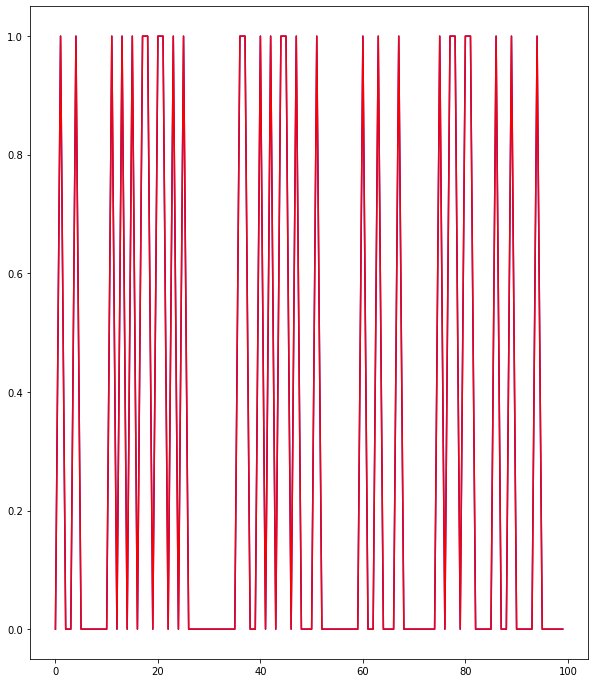

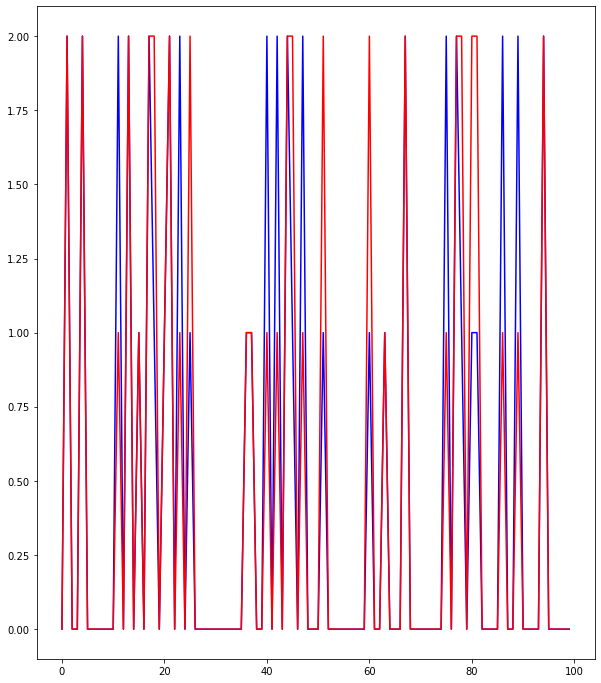

In [64]:
'''Visualize Prediction'''
#우범여부.
fig = plt.figure(figsize=(10, 12))
chart = fig.add_subplot(1, 1, 1)
chart.plot(y_test[:100], color='b')
chart.plot(preds[:100], color='r')

#핵심적발.
fig = plt.figure(figsize=(10, 12))
chart = fig.add_subplot(1, 1, 1)
chart.plot(zy_test[:100], color='b')
chart.plot(z_preds[:100], color='r')

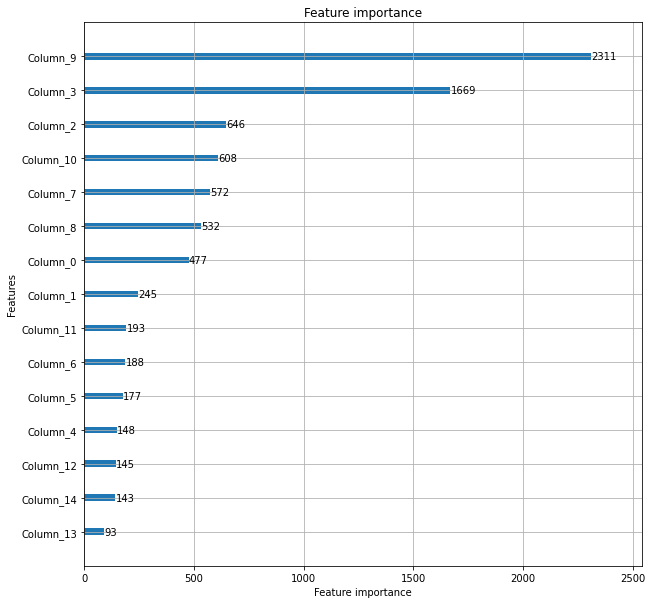

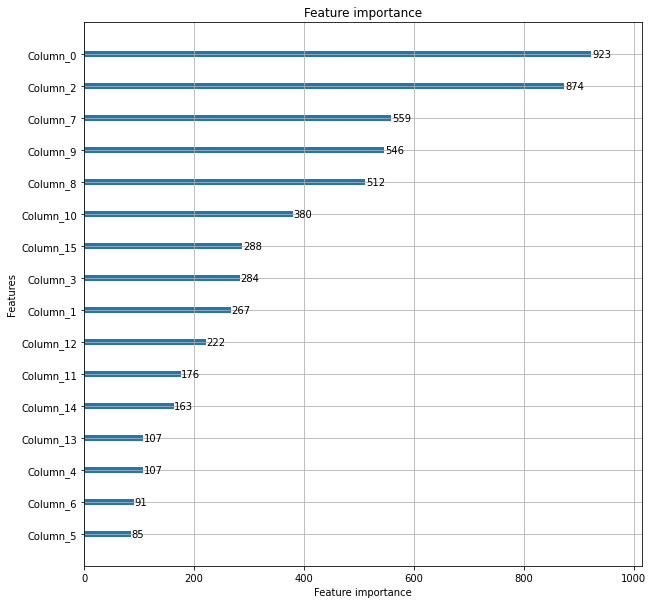

In [65]:
'''#Visualize Feature Importance'''
#우범여부.
fig, ax = plt.subplots(figsize=(10, 10))
plot_importance(lgbm, ax=ax)

#핵심적발.
fig, ax = plt.subplots(figsize=(10, 10))
plot_importance(zlgbm, ax=ax)

# Test

## Import

In [111]:
tdataset = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/HighRiskCargo/test.csv") 
tdataset.fillna('NaN', inplace=True)
#tdataset.pop("검사결과코드")

In [ ]:
#Check tdataset.
tdataset

In [ ]:
#Check tdataset.info().
tdataset.info()

## One-hot Encoding

In [114]:
#One-hot Encoding.
tdataset_copy = tdataset.copy()
to_convert_field_list = ['신고일자', '신고인부호', '수입자부호', '해외거래처부호', '특송업체부호', '수입통관계획코드',
                    '수입신고구분코드', '적출국가코드', '원산지국가코드', '관세율구분코드']

label_encoder_list = [OneHotEncoder(sparse=False) for i in to_convert_field_list]
convert_result_list = [0 for i in to_convert_field_list]

for idx, val in enumerate(to_convert_field_list):
  convert_result_list[idx] = label_encoder_list[idx].fit_transform(tdataset_copy[[val]].astype(str))
  #tdataset[val] = np.argmax(convert_result_list[idx])
  tdataset_copy[val] = [np.where(r==1)[0][0] for r in convert_result_list[idx]]

tdataset_encoded = tdataset_copy

In [ ]:
#Check tdataset_encoded.
tdataset_encoded

In [ ]:
#Check tdataset.info().
tdataset_encoded.info()

In [ ]:
#Label Encoding.
'''
to_convert_field_list = ['신고일자', '신고인부호', '수입자부호', '해외거래처부호', '특송업체부호', '수입통관계획코드',
                    '수입신고구분코드', '적출국가코드', '원산지국가코드', '관세율구분코드']

label_encoder_list = [LabelEncoder() for i in to_convert_field_list]
convert_result_list = [0 for i in to_convert_field_list]

for idx, val in enumerate(to_convert_field_list):
  convert_result_list[idx] = label_encoder_list[idx].fit_transform(tdataset[val]) 
  tdataset[val] = convert_result_list[idx]

tdataset
'''

## Data Preporcessing

In [118]:
tdataset_copy = tdataset_encoded.copy()

tdataset_copy["해외거래처부호"] = tdataset_copy["해외거래처부호"] / 10
tdataset_copy["신고중량(KG)"] = tdataset_copy["신고중량(KG)"] / 10
tdataset_copy["HS10단위부호"] = tdataset_copy["HS10단위부호"] / 1000
tdataset_copy["특송업체부호"] = tdataset_copy["특송업체부호"] / 10
tdataset_copy["반입보세구역부호"] = tdataset_copy["반입보세구역부호"] / 100

tdataset_last = tdataset_copy

In [ ]:
#Check dataset_encoded.
tdataset_encoded

In [ ]:
#Check dataset_last.
tdataset_last

## Data Split

In [121]:
#Transpose DataFrame to Numpy Array.
tdataset_np_x = tdataset_last.drop(["수입신고구분코드", "신고번호",
                                    "수입종류코드", "운송수단유형코드",
                                    "신고인부호", "수입자부호"], axis=1).values

## Model (Light GBM)

In [122]:
#Predict 우범여부.
predict = lgbm.predict(tdataset_np_x)
predict_proba = lgbm.predict_proba(tdataset_np_x)[:, 1]

In [123]:
#Data Split for 핵심적발.
tdataset_drop = tdataset_last.drop(["수입신고구분코드", "신고번호",
                                    "수입종류코드", "운송수단유형코드",
                                    "신고인부호", "수입자부호"], axis=1)
tdataset_drop.insert(15, '우범여부', predict)
tdataset_np_x = tdataset_drop

In [124]:
#Predict 핵심적발.
z_predict = zlgbm.predict(tdataset_np_x)
z_predict_proba = zlgbm.predict_proba(tdataset_np_x)[:, 1]

## Result

In [125]:
result = pd.DataFrame(columns = ['신고번호', '우범여부', '핵심적발'])
result['신고번호'] = tdataset['신고번호']

In [126]:
result['우범여부'] = predict
result['핵심적발'] = z_predict

In [ ]:
result.to_csv("./SSUML.csv", encoding="UTF-8", index=None)
print(result)

In [ ]:
for i in predict:
  print(i, end='')

In [ ]:
for i in z_predict:
  print(i, end='')

In [ ]:
if tdataset['신고번호'].equals(result['신고번호']):
  print("Same !")
else:
  print("No !")

# Temp

## 특송업체부호 확인 (X)

In [86]:
'''
print(dataset_last['특송업체부호'].mean())
print(dataset_last['특송업체부호'].min())
print(dataset_last['특송업체부호'].max())
print(dataset_last['특송업체부호'].var())
'''

5.733560963635533
0.0
9.9
4.739269440173336


## 이상치 확인 (X)

In [87]:
'''
# IQR 기반 예제 코드
def outliers_iqr(ys):
    quartile_1, quartile_3 = np.percentile(ys, [25, 75])
    iqr = quartile_3 - quartile_1
    lower_bound = quartile_1 - (iqr * 1.5)
    upper_bound = quartile_3 + (iqr * 1.5)
    print(lower_bound)
    print(upper_bound)
    return np.where((ys > upper_bound) | (ys < lower_bound))
'''

In [ ]:
'''
temp = outliers_iqr(dataset_last['특송업체부호'][0])
print(dataset_last['특송업체부호'][0])
print(temp)
'''